# PySP开发测试区

## 0. 测试准备

### 0.1 测试环境导入

In [1]:
import numpy as np
from numpy import random

import PySP

### 0.2 测试数据导入

In [2]:
fs=2000
t=np.arange(0,10,1/fs)

> 导入测试数据1: 平稳随机信号

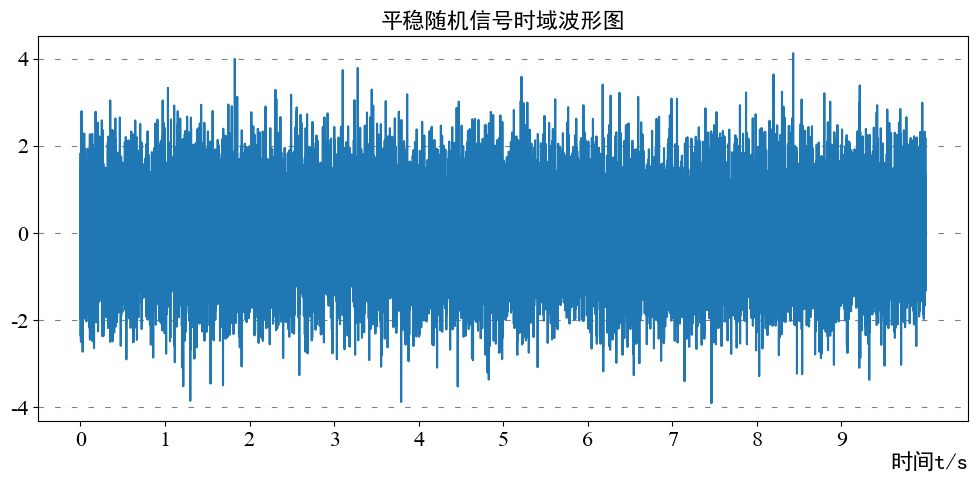

In [3]:
data=random.randn(len(t))
Sig_test=PySP.Signal.Signal(data=data,fs=fs,label='平稳随机信号')
Sig_test.plot()

### 0.3 测试对象导入

In [3]:
from PySP.Signal import Signal
from PySP.Signal import Analysis
from PySP.Plot import plot_2D_Anim

## 1. Signal模块测试

In [10]:
Sig=Signal(data=Sig_test.data,fs=Sig_test.fs,label='平稳随机信号')
np.mean(Sig)

np.float64(-0.0028067069890022485)

## 2. Plot模块测试

In [7]:
data_list = []
for i in range(10):
    data = random.randn(len(t))
    data_list.append(data)
dataArray = np.array(data_list)
plot_2D_Anim(
    t,
    dataArray,
    xlabel="时间t(s)",
    ylabel="幅值",
    framelabel=[f"第{i+1}次实验" for i in range(len(dataArray))],
    frameFps=10,
    linecolor="black",
)